In [2]:
%tensorflow_version 1.x
import numpy as np 
import pandas as pd
import os
import collections

!pip3 install bert-tensorflow

from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.contrib import rnn
import tensorflow_hub as hub
from datetime import datetime

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

     |████████████████████████████████| 71kB 2.3MB/s 



In [5]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2020-05-29 08:49:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   198MB/s    in 2.0s    

2020-05-29 08:49:20 (198 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
BERT_VOCAB= 'uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = 'uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = 'uncased_L-12_H-768_A-12/bert_config.json'

In [0]:
#tokenizer
tokenization.validate_case_matches_checkpoint(True,BERT_INIT_CHKPNT)
tokenizer = tokenization.FullTokenizer(vocab_file=BERT_VOCAB, do_lower_case=True)

In [0]:
from google.colab import auth
auth.authenticate_user()

In [11]:
!gsutil cp gs://toxiccommentclassification/train.csv train.csv
!gsutil cp gs://toxiccommentclassification/test.csv test.csv
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

Copying gs://toxiccommentclassification/train.csv...
- [1 files][ 65.6 MiB/ 65.6 MiB]                                                
Operation completed over 1 objects/65.6 MiB.                                     
Copying gs://toxiccommentclassification/test.csv...
- [1 files][ 57.6 MiB/ 57.6 MiB]                                                
Operation completed over 1 objects/57.6 MiB.                                     


In [15]:
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
55443,942801ad8f1f5557,"don't thumbnail it, insert it like this,\n 199...",0,0,0,0,0,0
79997,d612437220d5df26,"Thank you for your apology. I accept it, such ...",0,0,0,0,0,0
133850,cc1228368707e0ea,"You have a point, though I really like the rai...",0,0,0,0,0,0
136954,dcb8e6555259c994,! IT WAS MENTIONED IN THE MOVIE THAT SHE WAS H...,0,0,0,0,0,0
16116,2a8a60ea9f8cb544,Alpa Discucssion expansion \n\nHi SimonP\n\nI'...,0,0,0,0,0,0


In [0]:
ID = 'id'
DATA_COLUMN = 'comment_text'
LABEL_COLUMNS = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [0]:
class InputExample(object):
    def __init__(self, guid, text_a, text_b=None, labels=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    def __init__(self, input_ids, input_mask, segment_ids, label_ids, is_real_example=True):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids,
        self.is_real_example=is_real_example

In [0]:
def create_examples(df, labels_available=True):
    examples=[]
    for (i, row) in enumerate(df.values):
        guid = row[0]
        text_a = row[1]
        if labels_available:
            labels = row[2:]
        else:
            labels = [0,0,0,0,0,0]
        examples.append( InputExample(guid=guid, text_a=text_a, labels=labels))
    return examples

In [0]:
TRAIN_VAL_RATIO = 0.9
LEN = train.shape[0]
SIZE_TRAIN = int(TRAIN_VAL_RATIO*LEN)
x_train = train[:SIZE_TRAIN]
x_val = train[SIZE_TRAIN:]
train_examples = create_examples(x_train)

In [0]:
train.shape, x_train.shape, x_val.shape

((159571, 8), (143613, 8), (15958, 8))

In [0]:
import pandas

def convert_examples_to_features(examples,  max_seq_length, tokenizer):
    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)
        tokens_b = None
        
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]
        
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)

        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(int(label))
        
        inp_feat = InputFeatures(input_ids=input_ids,input_mask=input_mask,
                                 segment_ids=segment_ids,label_ids=labels_ids)

        features.append(inp_feat)
        
    return features

In [0]:
# NEEDED FOR BERT SEQUENCE OUTPUT WITH ATTENTION
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()#trainable weights 
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        #hidden shape == (batch_size, hidden size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) #(8,1,768)

        #score shape == (batch_size, max_length, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) #(8,20,1)

        #attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)      #(8,20,1)

        #context_vector shape after sum == (batch_size, hidden_size
        context_vector = attention_weights * features                #(8,20,768)
        context_vector = tf.reduce_sum(context_vector, axis=1)       #(8,768)
        return context_vector, attention_weights

In [0]:
def create_attention_model(bert_config, is_training, input_ids, input_mask, segment_ids,labels, num_labels, use_one_hot_embeddings):
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    #get sequence output from BERT 
    output_layer = model.get_sequence_output()

    print(output_layer.shape)
    
    output_weights = tf.get_variable(
        "output_weights", [num_labels, 768],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        #token embeddings of first 20 tokens 
        t1=output_layer[:,1:126]
        print(t1.shape)
        #token embedding of [CLS] token
        t2=output_layer[:,0]

        #compute context vector
        context_vector, attention_weights = Attention(5)(t1,t2)
        
        #set the last layer to context vector
        output_layer=context_vector

        if is_training:
            # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        #compute logits W.X+b
        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)

        #compute sigmoid probabilities 
        probabilities = tf.nn.sigmoid(logits)
        
        #convert to float32
        labels = tf.cast(labels, tf.float32)

        #compute the loss
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)

        loss = tf.reduce_mean(per_example_loss)

        return (loss, per_example_loss, logits, probabilities)


def create_lstm_model(bert_config, is_training, input_ids, input_mask, segment_ids,labels, num_labels, use_one_hot_embeddings):
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    #get sequence output from BERT 
    output_layer = model.get_sequence_output()

    print(output_layer.shape)
    
    output_weights = tf.get_variable(
        "output_weights", [num_labels, 768],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        #token embeddings of first 20 tokens 
        t1=output_layer[:,1:126]
        print(t1.shape)
        #token embedding of [CLS] token
        t2=output_layer[:,0]

        #compute lstm cell state vector
        lstmcell =  tf.nn.rnn_cell.LSTMCell(768, state_is_tuple=True)
        outputs, states = tf.nn.dynamic_rnn(lstmcell,
                                  t1,
                                  sequence_length=[20]*t1.shape[0].value,
                                  dtype=tf.float32)
    
        output_layer=tf.reduce_mean([t2,states.h],0)  

        if is_training:
            # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        #compute logits W.X+b
        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)

        #compute sigmoid probabilities 
        probabilities = tf.nn.sigmoid(logits)
        
        #convert to float32
        labels = tf.cast(labels, tf.float32)

        #compute the loss
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)

        loss = tf.reduce_mean(per_example_loss)

        return (loss, per_example_loss, logits, probabilities)




def create_simple_model(bert_config, is_training, input_ids, input_mask, segment_ids,labels, num_labels, use_one_hot_embeddings):
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    #get sequence output from BERT 
    output_layer = model.get_pooled_output()

    print(output_layer.shape)
    
    output_weights = tf.get_variable(
        "output_weights", [num_labels, 768],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        if is_training:
            # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        #compute logits W.X+b
        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)

        #compute sigmoid probabilities 
        probabilities = tf.nn.sigmoid(logits)
        
        #convert to float32
        labels = tf.cast(labels, tf.float32)

        #compute the loss
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)

        loss = tf.reduce_mean(per_example_loss)

        return (loss, per_example_loss, logits, probabilities)




def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,num_train_steps, num_warmup_steps, use_tpu,use_one_hot_embeddings,model_type=""):

    def model_fn(features, labels, mode, params): 
        

        # input ids which are obtained from bert tokenizer
        input_ids = features["input_ids"]

        # input masks to represent the actual sentence (1's along length of sentence , 0's for padding) and padding sequence
        input_mask = features["input_mask"]
        
        # segment ids to distinguish in case of two sentence tasks (not needed for this task)
        segment_ids = features["segment_ids"]

        # label for sentence 
        label_ids = features["label_ids"]

        is_training = (mode == tf.estimator.ModeKeys.TRAIN)


        if model_type=="attention":
            (total_loss, per_example_loss, logits, probabilities) = create_attention_model(
                          bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
                          num_labels, use_one_hot_embeddings)
        elif model_type=="lstm":
            (total_loss, per_example_loss, logits, probabilities) = create_lstm_model(
                          bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
                          num_labels, use_one_hot_embeddings)
        else:
            (total_loss, per_example_loss, logits, probabilities) = create_simple_model(
                          bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
                          num_labels, use_one_hot_embeddings)

        tvars = tf.trainable_variables()
        initialized_variable_names = {}

        if init_checkpoint:
            (assignment_map, initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

        for var in tvars:
            init_string = ""
            if var.name in initialized_variable_names:
                init_string = ", *INIT_FROM_CKPT*"

        output_spec = None

        if mode == tf.estimator.ModeKeys.TRAIN:

            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

            output_spec = tf.estimator.EstimatorSpec(mode=mode,
                                            loss=total_loss,
                                            train_op=train_op,
                                            scaffold=None)
          
        else:
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions={"probabilities": probabilities},
                scaffold=None)
        return output_spec

    return model_fn

In [0]:
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
WARMUP_PROPORTION = 0.1
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

In [0]:
OUTPUT_DIR = "/content/output/output"
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    keep_checkpoint_max=1,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    all_label_ids = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.segment_ids)
        all_label_ids.append(feature.label_ids)

    def input_fn(params):

        batch_size = params["batch_size"]

        num_examples = len(features)

        d = tf.data.Dataset.from_tensor_slices({
            "input_ids":
                tf.constant(
                    all_input_ids, shape=[num_examples, seq_length],
                    dtype=tf.int32),

            "input_mask":
                tf.constant(
                    all_input_mask,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),

            "segment_ids":
                tf.constant(
                    all_segment_ids,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),

            "label_ids":
                tf.constant(all_label_ids, shape=[num_examples, len(LABEL_COLUMNS)], dtype=tf.int32),
        })

        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
        return d

    return input_fn

In [0]:
def convert_single_example(ex_index, example, max_seq_length,
                           tokenizer):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, DummyInputExample):
        return InputFeatures(
            input_ids=[0] * max_seq_length,
            input_mask=[0] * max_seq_length,
            segment_ids=[0] * max_seq_length,
            label_ids=0,
            is_real_example=False)

    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    labels_ids = []
    for label in example.labels:
        labels_ids.append(int(label))


    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_ids=labels_ids,
        is_real_example=True)
    return feature


def file_based_convert_examples_to_features(
        examples, max_seq_length, tokenizer, output_file):
    writer = tf.python_io.TFRecordWriter(output_file)

    for (ex_index, example) in enumerate(examples):
        feature = convert_single_example(ex_index, example,
                                         max_seq_length, tokenizer)

        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f

        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["is_real_example"] = create_int_feature(
            [int(feature.is_real_example)])
        if isinstance(feature.label_ids, list):
            label_ids = feature.label_ids
        else:
            label_ids = feature.label_ids[0]
        features["label_ids"] = create_int_feature(label_ids)

        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())
    writer.close()


def file_based_input_fn_builder(input_file, seq_length, is_training,
                                drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    name_to_features = {
        "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.FixedLenFeature([6], tf.int64),
        "is_real_example": tf.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        example = tf.parse_single_example(record, name_to_features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t

        return example

    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        # For training, we want a lot of parallel reading and shuffling.
        # For eval, we want no shuffling and parallel reading doesn't matter.
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.apply(
            tf.contrib.data.map_and_batch(
                lambda record: _decode_record(record, name_to_features),
                batch_size=batch_size,
                drop_remainder=drop_remainder))

        return d

    return input_fn


def _truncate_seq_pair(tokens_a, tokens_b, max_length):

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()
            
class DummyInputExample(object):
    pass

In [27]:
#from pathlib import Path
train_file = os.path.join("train.tf_record")
#filename = Path(train_file)
if not os.path.exists(train_file):
    open(train_file, 'w').close()
train_file

'train.tf_record'

In [28]:
num_train_steps = int(len(train_examples) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
num_train_steps

17951

In [34]:
!gsutil cp -r gs://toxiccommentclassification/output/ output

Copying gs://toxiccommentclassification/output/checkpoint...
Copying gs://toxiccommentclassification/output/events.out.tfevents.1590732301.toxic...
Copying gs://toxiccommentclassification/output/graph.pbtxt...
Copying gs://toxiccommentclassification/output/model.ckpt-17951.data-00000-of-00001...
/ [4 files][  1.2 GiB/  1.2 GiB]   75.0 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://toxiccommentclassification/output/model.ckpt-17951.index...
Copying gs://toxiccommentclassification/output/model.ckpt-17951.meta...
Copying gs://toxiccommentclassification/output/train.tf_record...
\ [7 files][  1.3 GiB/  1.3 GiB]   69.2 MiB/s                                   
Operation completed over 7 objects/1.3 GiB.                                   

In [0]:
MAX_SEQ_LENGTH=128
file_based_convert_examples_to_features(train_examples, MAX_SEQ_LENGTH, tokenizer, train_file)

In [0]:
MAX_SEQ_LENGTH=128
train_input_fn = file_based_input_fn_builder(
                input_file=train_file,
                seq_length=MAX_SEQ_LENGTH,
                is_training=True,
                drop_remainder=True)

In [41]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
model_fn = model_fn_builder(
  bert_config=bert_config,
  num_labels= len(LABEL_COLUMNS),
  init_checkpoint=BERT_INIT_CHKPNT,
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=False,
  use_one_hot_embeddings=False,
  model_type="attention")

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size":BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/output/output', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc9a4ba4630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [42]:
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [108]:
inp=input("enter text:")
data=[["100aaa",inp]]
test=pd.DataFrame(data=data,columns=["id","comment_text"])
test_examples = create_examples(test,False)
test_file="test.tf_record"
file_based_convert_examples_to_features(test_examples, MAX_SEQ_LENGTH, tokenizer, test_file)
predict_input_fn = file_based_input_fn_builder(
    input_file=test_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)
predictions = estimator.predict(predict_input_fn)
probabilities=None
for it in predictions:
  probabilities=it["probabilities"]

enter text:Pakistan terrorists are planning to kill Indians 
INFO:tensorflow:Calling model_fn.
(?, 128, 768)
(?, 125, 768)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/output/output/model.ckpt-17951
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


CATEGORY::::PROBABILITY
toxic::::0.89419854
severe_toxic::::0.045063224
obscene::::0.14746724
threat::::0.09462587
insult::::0.20482463
identity_hate::::0.69885457


<BarContainer object of 6 artists>

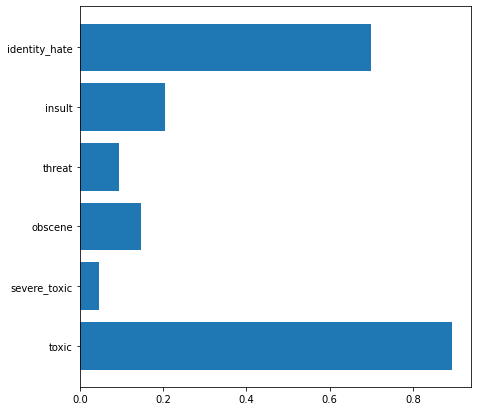

In [109]:
print("CATEGORY::::PROBABILITY")
for k,v in zip(LABEL_COLUMNS,probabilities):
  print(k,v,sep="::::")
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(7,7))
plt.xticks(np.arange(0,1,0.2))
plt.barh(LABEL_COLUMNS,probabilities)